In [1]:
import os
import sys
sys.path.append(os.chdir('../../'))

In [22]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np

import matplotlib.pyplot as plt
import plotly.plotly as ply
import plotly.graph_objs as go
import src.utils.graph as graph
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

tqdm.pandas()
pd.options.display.max_columns = None

In [3]:
import src.data as data
import src.utility as utility

In [4]:
sensors = data.sensors()

s1 = data.speeds('train').merge(sensors, how='left')
#s2 = data.speeds('test').merge(sensors, how='left')

e1 = data.events('train')
#e2 = data.events('test')

caching sensors

sensors loaded in: 0.007 s

shape of the dataframe is: (2171, 5)
caching resources/dataset/originals/speeds_train.csv.gz
caching resources/dataset/preprocessed/events_train.csv.gz


In [5]:
road = 0

In [6]:
joined = utility.merge_speed_events(s1, e1)

In [2]:
#graph.show_speeds_with_events(joined, road, from_datetime='2018-9-1', to_datetime='2019-5-1', limit_sensors=5)

In [155]:
def show_speeds_with_events2(speed_df, road_key, from_datetime='2018-11-15', to_datetime='2018-11-17', event_marker='*'):
    spe = speed_df[speed_df.KEY == road_key].sort_values('DATETIME_UTC')
    spe = spe[(spe.DATETIME_UTC >= pd.to_datetime(from_datetime)) & (spe.DATETIME_UTC <= pd.to_datetime(to_datetime))]

    # get all the sensors of the road
    sensors_km = sorted(spe.KM.unique())
    sensors_count = len(sensors_km)

    print('Number of sensors in road {}: {}'.format(road_key, sensors_count))
    #print('Number of events: {}'.format(number_of_events))
    #print('Lanes: {}'.format(number_of_lanes))
    
    plots = []
    plots_info = []
    # add the series
    for km in sensors_km:
        # get the speeds for the sensor
        sensor_speeds = spe[spe.KM == km]
        number_of_lanes = sensor_speeds.LANES.values[0]
        linewidth = number_of_lanes / 2
        
        # events involving the sensor
        sensor_events = sensor_speeds[sensor_speeds['index'].notnull()]
        event_ids = sensor_events['index'].unique() #.astype(int)
        number_of_events = len(event_ids)
        
        # add the speed plot
        plots.append( go.Scatter(x=sensor_speeds.DATETIME_UTC, y=sensor_speeds.SPEED_AVG, name=str(km),
                             mode='lines', marker={ 'line':{ 'width': linewidth } }) )
        # add the events scatter plots if present
        if(number_of_events > 0):
            for evt_id in event_ids:
                e = sensor_events[sensor_events['index'] == evt_id]
                plots.append( go.Scatter(x=e.DATETIME_UTC, y=e.SPEED_AVG, mode='markers', 
                                 name=f'{[evt_id]} {e.EVENT_TYPE.values[0]} (road {e.KM.values[0]})') )
        
        plots_info.append( (str(km), number_of_events+1, number_of_lanes, len(sensor_speeds.DATETIME_UTC) ) )
    
    buttons = []
    total_plots = sum([l[1] for l in plots_info])
    current = 0
    for pi in plots_info:
        buttons.append( { 'label': pi[0],
             'method': 'update',
             'args': [  {'visible': [((j >= current) and (j < current+pi[1])) for j in range(total_plots)] },
                        {'title': f'Sensor {pi[0]} ({pi[2]} lanes) - {pi[3]} data points - {pi[1]-1} events' }
                     ]})
        current += pi[1]
    
    # add the dropdowns
    updatemenus = [{ 'active':-1, 'buttons':buttons }]
    
    iplot({'data':plots, 'layout': {'updatemenus':updatemenus} })

Number of sensors in road 0: 13


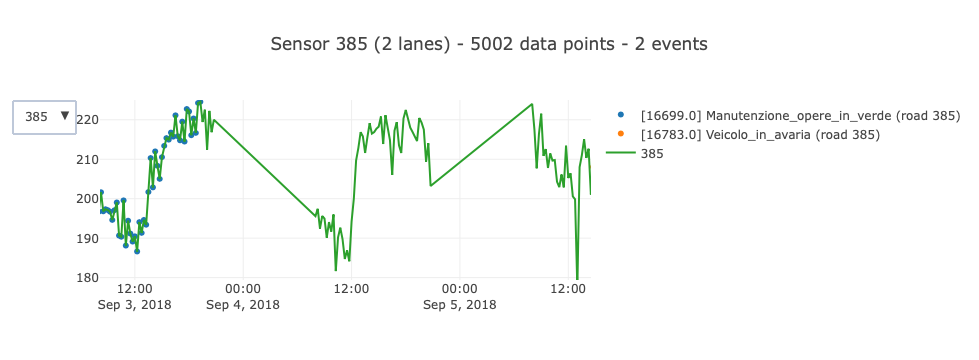

In [154]:
show_speeds_with_events2(joined, road_key=road, from_datetime='2018-01-01', to_datetime='2019-12-30')